# Tutorial: Point Cloud Deep Learing With Forest Lidar Data

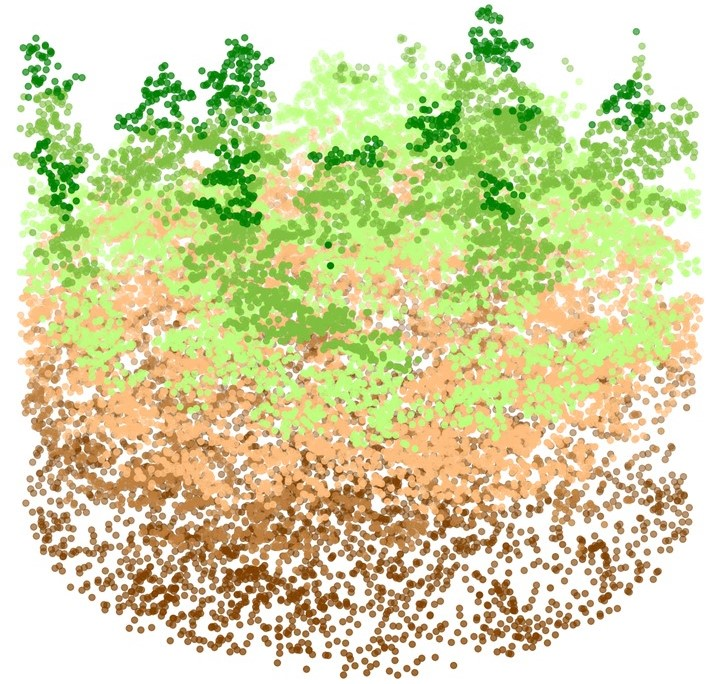

By Harry Seely

This is a simple tutorial to get you started with using a point cloud deep learning model to process forest lidar data.

While deep learning is a but tough to use at first, once you get the hang of it you can begin to appreciate the flexibility and power of these models.

If you would like more information on point cloud deep learning, check out my repo [https://github.com/harryseely/DL_Biomass](https://github.com/harryseely/DL_Biomass)


This tutorial was developed using python v3.8

All you need to run it is a python environment setup with jupyter notebook installed.


In [ ]:
#First check python version
from platform import python_version
print(python_version())

In [ ]:
#Install requirements
# !pip install torch torchvision torchaudio
# !pip install matplotlib
# !pip install ipywidgets
# !pip install tqdm

In [ ]:
#Load required modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import math

## Sample Point Cloud Data

So lets start with some simple point clouds. How about 12 forest plots point clouds each which has 7168 points or 18 pts/m^2  (to keep file size small). It is required for most neural networks that each input file has the same dimensions, which is why the point clouds need to be pre-processed to have the same number of points.

In [ ]:
#Get our files
train_data_dir = r"data\train"
glob = "*.npy"

#Read in all files
files = list(Path(train_data_dir).glob(glob))
print(files)

In [ ]:
#Load point cloud from numpy file
points = np.load(files[0])

# Extract xyz only
xyz = points[:, 0:3]

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=[30, 30])

# set up the axes for the first plot
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=xyz[:, 2], linewidth=1, s=50)

Ok so its a bit hard to see in this figure but this is a 11.28m (399.7m2) forest plot

For a simple initial modelling task, we can get the model to predict the average height for each plot. Lets calculate that for every plot in our dataset.

In [ ]:
#For example, this plot has a mean height of:
np.mean(points[:,2])

## Dataset Class

The first thing we need to develop to get a pytorch DL model up and running is a dataset class. This is used to load data into our model during training. We can define a simple one below.

In [ ]:
class PointCloudDataset(Dataset):
    """Point cloud dataset where one data point is a file."""

    def __init__(self, data_dir):

        self.files = []
        for file in os.listdir(data_dir):
            filepath = os.path.join(data_dir, file)
            self.files.append(filepath)

        super().__init__()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        filepath = str(self.files[idx])

        # Read in point cloud from NPY
        points = np.load(filepath)
        points = points[:,:3] #Filter to xyz coords only

        #Get mean height
        mean_z = np.mean(points[:,2])

        # Return point cloud coords + features (points), biomass targets, and PlotID for one sample
        sample = {
            # Swap rows and cols of points tensor to fit required shape for most models
            'points': torch.from_numpy(points).float().permute(1, 0),
            'target': torch.from_numpy(np.array(mean_z)).float(),
        }

        return sample


#Lets test the Dataset class
train_dataset = PointCloudDataset(train_data_dir)

#Check length
print("Number of samples:", len(train_dataset))

#Check one sample
data_iter = iter(train_dataset)
sample = next(data_iter)

print("\nSample info:\n")
print("Type: ", type(sample))
print("Shape: ", len(sample))
print("Points shape: ", sample["points"].shape)
print("Target: ", sample['target'])

We also need a class to load the data into the model in batches. A batch is a subset of data that passes through the model before the loss is calculated and the optimizer is implemented. For simplicity, we will use a batch size of 2.

In [ ]:
#Set up data loader (loads data into the model during each iteration)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

#Test the loader
train_loader_iter = iter(train_loader)
batch = next(train_loader_iter)
print("Batch shape explained:")
print("Batch size, Num points, XYZ coords")
print(batch['points'].shape)
print(f"Target:\n{batch['target']}")

## Define model

I asked ChatGPT to write me some code for a simple point cloud neural network with the prompt: "Write me a simple neural network similar to pointnet that can learn from point cloud data", and here it was it provided:

In [ ]:
class SimplePointNet(nn.Module):
    def __init__(self, num_outputs):
        super(SimplePointNet, self).__init__()

        self.num_outputs = num_outputs

        # MLP for each point
        self.mlp1 = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True)
        )

        # max pooling across all points
        self.pooling = nn.AdaptiveMaxPool1d(1)

        # MLP after pooling
        self.mlp2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, self.num_outputs) # k is the number of output classes
        )

    def forward(self, x):
        # x is a tensor of shape (batch_size, num_points, 3)

        # apply MLP to each point
        # x = x.transpose(1, 2) # (batch_size, 3, num_points)
        x = self.mlp1(x)

        # max pooling
        x = self.pooling(x)

        # flatten and apply MLP
        x = x.view(x.size(0), -1) # (batch_size, 1024)
        x = self.mlp2(x)

        return x

This is a VERY simple neural network that only has 2 layers, each with 64 neurons, for a total of 128 neurons.

Let's view the model architecture and then test the model:

In [ ]:
model = SimplePointNet(num_outputs=1)
print(model)
model(batch['points'])

## Validation and Test Datasets

In [ ]:
#For model training, we also need a validation dataset to see when the model starts to overfit the training data
val_data_dir = r"D:\Sync\IRSS_Github_Organization\Tutorials\Point Cloud Deep Learning\data\val"
val_dataset = PointCloudDataset(val_data_dir)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)

#We also need another seperate test dataset to evaluate final model performance after trainin
test_data_dir = r"D:\Sync\IRSS_Github_Organization\Tutorials\Point Cloud Deep Learning\data\test"
test_dataset = PointCloudDataset(test_data_dir)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

The loss function is how the way you measure model accuracy. In this case since it is a regression problem, let use Mean Squared Error (MSE).

The optimizer is a function that uses complex calculus and linear algebra to adjust the model neurons after each training iteration based on the loss. For example, if the loss is very large, the optimizer might make big changes to the network parameters, if it is small, then the opposite may occur.

The learning rate (lr) determines how fast/slow our optimizer helps our model learn. Larger learning rate = faster, but more chaotic learning.

In [ ]:
#Set up a loss function and an optimizer.
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

## Training Loop

Deep learning models are trained by iteratively passing the dataset through the network and then adjusting the neuron parameters (i.e., weights) based on each iteration.

Once the entire training dataset has moved through the model, this is considered to be 1 epoch.

Deep learning models are often trained for 100s or 1000s of epochs.

The dataloader will load one or several samples during each iteration within an epoch. The number of samples loaded during an iteration is determined by the batch size. Here we will use a batch size of 1. Batch size can be larger though. For example, ChatGPT was trained using a batch size of 2 Million pieces of text.

Once the batch is loaded, it is processed through the model, the model makes a prediction, the loss (i.e., error) is calculated, and then the optimizer is used to adjust the model parameters.

In [ ]:
#Create lists to store step and epoch loss values
step_train_losses = []
step_val_losses = []
mean_epoch_train_losses = []
mean_epoch_val_losses = []

num_epochs = 25

for epoch in range(num_epochs):

    #Train loop
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(batch['points'])
        target = torch.reshape(batch['target'], (batch['target'].shape[0], 1))
        loss = loss_fn(pred, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        step_train_losses.append(loss)

    #Validation loop
    for step, batch in enumerate(val_loader):
        optimizer.zero_grad()
        pred = model(batch['points'])
        target = torch.reshape(batch['target'], (batch['target'].shape[0], 1))
        loss = loss_fn(pred, target).item()
        step_val_losses.append(loss)
    
    mean_train_loss = np.mean(step_train_losses)
    mean_val_loss = np.mean(step_val_losses)
    print(f"Epoch {epoch} - val loss: {mean_val_loss} - train loss {mean_train_loss}")

    mean_epoch_train_losses.append(mean_train_loss)
    mean_epoch_val_losses.append(mean_val_loss)

In [ ]:
fig1, ax1 = plt.subplots()

ax1.plot(list(range(num_epochs)), mean_epoch_train_losses, color="blue", marker="o")
ax1.plot(list(range(num_epochs)), mean_epoch_val_losses, color="red", marker="o")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")

#Add legend
red_patch = mpatches.Patch(color='red', label='Validation')
blue_patch = mpatches.Patch(color='blue', label='Training')
plt.legend(handles=[red_patch, blue_patch])

In [ ]:
#Lists to store vals
test_losses = []

#Lets apply the model to the test dataset now
for step, batch in enumerate(test_loader):
    optimizer.zero_grad()
    pred = model(batch['points'])
    target = torch.reshape(batch['target'], (batch['target'].shape[0], 1))
    loss = loss_fn(pred, target)

    #Add items to lists
    test_losses.append(loss)

test_losses = [loss.detach().numpy() for loss in test_losses]
print("Test MSE: ", np.mean(test_losses), "m")
print("Model can predict mean height within +/-", np.round(math.sqrt(np.mean(test_losses)), 0), "m")

So overall, this is a little underwhelming since the modelling task is so easy... However, for the purpose of demonstration, this is fine. There are several ways we could make our model better, including:

1. Increasing the size of our dataset.
2. Increasing the complexity of our model.
3. Fine tuning hyperparameter (e.g., learning rate)

...many more tricks...



## Conclusion

In conclusion, point cloud deep learning is a new perspective on how to model point cloud data, and may have a lot of potential for improving our ability to estimate forest attributes. However, these models are currently quite hard to implement, and are VERY sensitive to small changes in data or hyperparameters. As such, projects using point cloud deep learning for lidar data should be approach with caution. In many cases, other types of models may be better suited to the task.
